# Processing code of SEVN data to study binary black holes mass distribution

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv
from scipy.spatial.distance import jensenshannon as JS

## Setting up the dask cluster made of Cloud Veneto VMs

In [2]:
#cluster.close()

In [3]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-07-03 07:54:39,211 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:39,210 - distributed.scheduler - INFO - State start
2023-07-03 07:54:39,214 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:39,212 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-rbcehea7', purging
2023-07-03 07:54:39,222 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:39,221 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.140:8786
2023-07-03 07:54:40,127 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:40,125 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43473'
2023-07-03 07:54:40,133 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:40,132 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:38321'
2023-07-03 07:54:40,136 - distributed.deploy.ssh - INFO - 2023-07-03 07:54:40,135 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.140:43873'
2023-07-03 07:54:40,141 -

In [4]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.3.2', '6.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

<Client: 'tcp://10.67.22.140:8786' processes=20 threads=20, memory=38.78 GiB>

## Reading the data

In [6]:
#defining the value of q to drop
q_drop = 0.2

#importing data
bhbh = dd.read_parquet('/home/ubuntu/data/bag_all_dataset_with_no_kick/*')

#Masking on the data

bhbh = bhbh[bhbh['q'] > q_drop] #dropping the value of q under q_drop

#bhbh = bhbh[ bhbh['No_Kick'] == 2] # taking only the binaries without kick

## Discretizing and introducing labels

In [7]:
#number of classes
n_bins = 100

# Define the edges between bins
counts, bin_edges = da.histogram(bhbh.q.values, bins=n_bins, range=(q_drop,1.0))

# pd.cut each column, with each bin closed on left and open on right
bhbh['label'] = bhbh['q'].map_partitions(pd.cut, bin_edges, right=True, labels=False, include_lowest=False)

## Splitting the data in train and test set

In [8]:
bhbh_train, bhbh_test = train_test_split(bhbh, train_size=0.7, random_state=1, shuffle=True)

#resetting indexes 
bhbh_train = bhbh_train.reset_index(drop=True) 
bhbh_test = bhbh_test.reset_index(drop=True)

## Sample weigths

We us sample weigths to deal with an unbalanced dataset. To define them we use a costum definition respect to the default one of XGBoost.

In [9]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)  #adding a column with weights

## Code to plot sample weights

## Rename of useful columns

In [10]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [11]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

Defining the parameters to train the XGBoost model.

Creating a DaskDMatrix for the training.

In [12]:
dtrain = xgb.dask.DaskDMatrix(client, features, label=labels, weight=weights)

# dtrain = xgb.dask.DaskDMatrix(client, features, label=labels) # without weight

Train the XGBoost model.

## Saving and loading the trained model

In [14]:
bst = xgb.Booster()
bst.load_model('bst0_400_new.json')

## Importance of each Feature
Plotting the importance of each feature in the training, with three different scores.

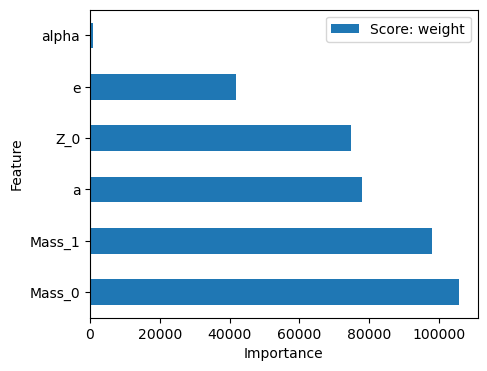

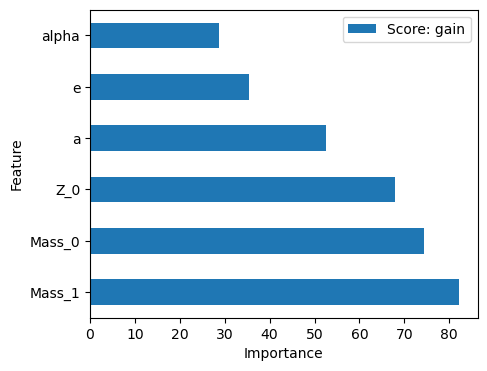

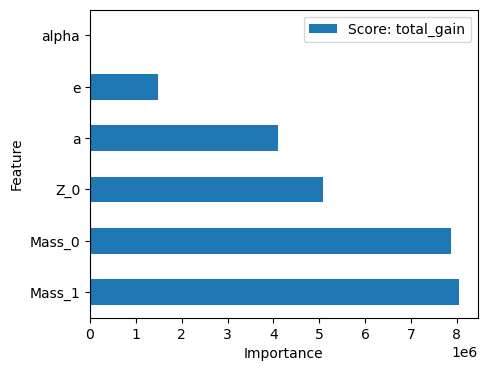

In [15]:
importances=['weight', 'gain', 'total_gain']
for im in importances:
    feature_important = bst.get_score(importance_type=im)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["Score: "+im]).sort_values(by = "Score: "+im, ascending=False)
    data.plot(kind='barh', figsize = (5,4)) ## plot top 40 features
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig('Figures/lcp/importance_q_yeskicks_'+im+'.png', bbox_inches='tight')

## Prediction on test

In [16]:
# distributions of the probability of each class for each record
output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

##Predicition of the label with Maximum estimation
predicted_label = output_test.idxmax(axis=1).persist()

# Computing the true labels and the predicted
Y_test = label_test.values.compute()
Y_predicted = predicted_label.values.compute()

## Code for the plot of some distributions as example

In [17]:
distributions = output_test.sample(frac=0.001)
distributions = distributions.compute()

Choosing three random distributions for the plot.

In [18]:
dist_1 = distributions.iloc[0,:]
dist_2 = distributions.iloc[1907,:]
dist_3 = distributions.iloc[1909, :]
labels = np.arange(0, 100,1)

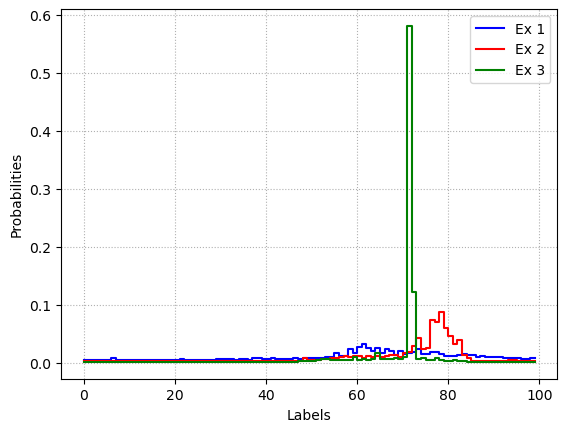

In [19]:
plt.step(labels, dist_1, c='blue', label = 'Ex 1')
plt.step(labels, dist_2, c='red', label = 'Ex 2')
plt.step(labels, dist_3, c='green', label = 'Ex 3')
plt.xlabel('Labels')
plt.ylabel('Probabilities')
plt.grid(linestyle = ':')
plt.legend()
plt.savefig('Figures/lcp/prob_dist_of_labels_peaked.png', bbox_inches='tight')

## Confusion matrix comparison of predicted respect to true labels

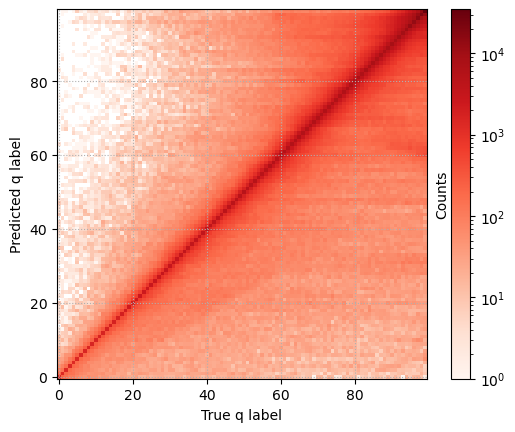

In [20]:
cm=confusion_matrix(Y_test, Y_predicted)
fig = plt.figure()
ax = fig.add_subplot(111)
pp=ax.matshow(cm.T, norm=colors.LogNorm(vmin=1, vmax=cm.max()), cmap='Reds', origin='lower')
cbar=fig.colorbar(pp)
cbar.ax.get_yaxis().labelpad = -50
cbar.ax.set_ylabel('Counts', rotation=90)
plt.grid(linestyle='dotted')
plt.gca().xaxis.tick_bottom()
plt.xlabel('True q label')
plt.ylabel('Predicted q label')
plt.savefig('Figures/lcp/confusion_matrix_labels_yeskicks.png', bbox_inches='tight')

# Metrics
Here we define some metrics to compare the performances of our models.

In [21]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

### Kulback-Leibler metrics

In [22]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

KL_div

0.011238856831920125

### JS (limited between 0 and 1 when base=2)

In [23]:
JS_div = JS(counts_test, counts_predicted, base=2)

JS_div

0.06236486359703623

## Histogram of the q distribution

Comparison of the true distribution and the predicted distribution on the test set.

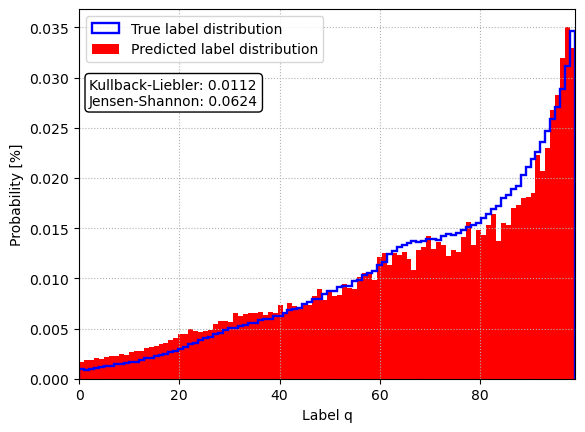

In [24]:
plt.hist(Y_test, bins=n_bins, label = 'True label distribution', histtype='step', density=True, color='blue',  linewidth=1.7)#, linestyle='dashed')
plt.hist(Y_predicted, bins=n_bins, label='Predicted label distribution', density=True, color='red')
plt.xlim(0,99)
plt.grid(linestyle='dotted')
plt.xlabel('Label q')
plt.ylabel('Probability [%]')
plt.text(2, 0.03, "Kullback-Liebler: {:.4f}\nJensen-Shannon: {:.4f}".format(KL_div, JS_div),
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   )
         )
plt.legend()
plt.savefig('Figures/lcp/hist_q_yes_kicks.png', bbox_inches='tight')

## Histogram of difference between true and predicted labels

Now we plot the distribution of the difference between true and predicted labels, computing also the 95% credibility intervall.



In [26]:
#95% interval 
diff = (Y_predicted-Y_test)
lower=np.quantile(diff, q=0.025) 
upper= np.quantile(diff, q=0.975)
print("95% credibility intervall:")
print(lower, upper)

95% credibility intervall:
-43.0 24.0


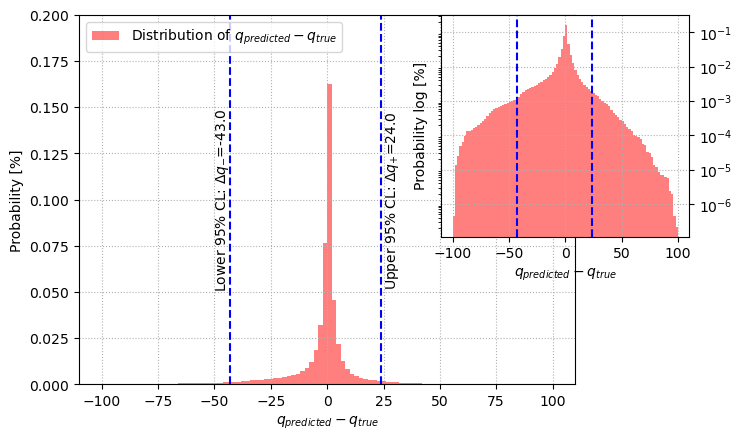

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.73, .4, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params(left=False, right=True, labelleft=False, labelright=True)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')
axins.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
           color='red', linewidth=1.7, log=True, histtype='stepfilled', alpha=0.5)
ax.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
         alpha=0.5, color='red', label=r'Distribution of $q_{predicted}-q_{true}$')
ax.legend(loc=2)
ax.set_ylabel("Probability [%]")
axins.set_ylabel("Probability log [%]")
ax.set_xlabel(r'$q_{predicted}-q_{true}$')
axins.set_xlabel(r'$q_{predicted}-q_{true}$')
ax.set_ylim(0,0.2)

ax.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
ax.axvline(x=upper, color='blue', linestyle='--');

axins.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
axins.axvline(x=upper, color='blue', linestyle='--');
ax.text(lower-7,0.1, r'Lower 95% CL: $\Delta q_{-}$='+str(lower), rotation=90, va='center')
ax.text(upper+1,0.1, r'Upper 95% CL: $\Delta q_{+}$='+str(upper), rotation=90, va='center')
plt.savefig('Figures/lcp/hist_delta_q_yeskicks.png',  bbox_inches='tight')
plt.show()

## Misura della accuracy

We define an accuracy that takes in account a threshold of tollerance in such a way that also predictions not too far from the true labels contributes to the accuracy.

In [30]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [31]:
accuracy_threshold(Y_test, Y_predicted, 25)

0.912088796948161

## Grid Search with For Loops

Code for the grid search on hyperparameter space.

## Clustering of probability distribution

We extract the firsts three peaks of each distribution.

In [32]:
# Defining a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [33]:
# Defining a function to order the peaks of the probability distribution
def extract_id_top_values(row, n_top=3):
    idx_sorted = np.argsort(row)[::-1]
    return np.array(idx_sorted)[:n_top]

In [34]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))
idx_top_values = output_test.apply(extract_id_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [35]:
top_values = top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

idx_top_values = idx_top_values.compute()
idx_top_values = pd.DataFrame(idx_top_values.to_list(), columns = ['1', '2', '3'])

for col in idx_top_values.columns:
    top_values[f'idx_{col}']=idx_top_values[col].values   
    
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

#adding features
X_test = features_test.compute()
for col in X_test.columns:
    top_values[col]=X_test[col].values

# Some interesting representations

### All the records

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


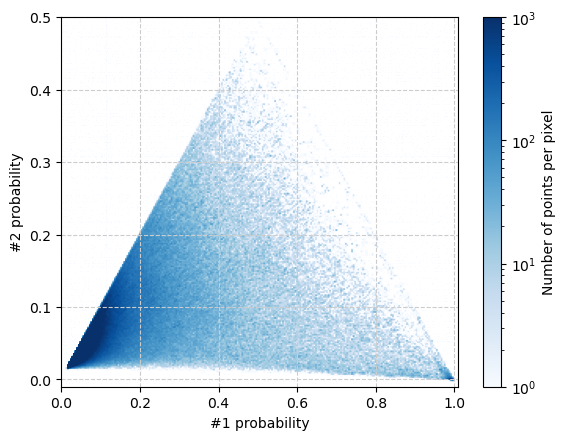

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values['1'], top_values['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/tops_q_yeskicks.png', bbox_inches='tight')
plt.show()

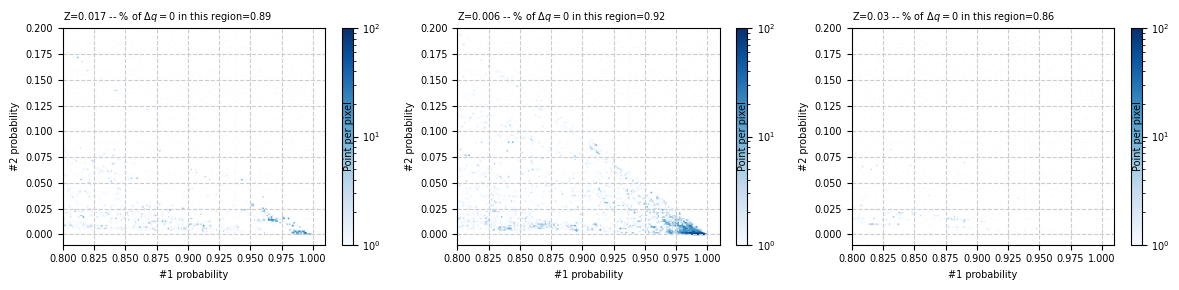

In [37]:
fontsize=7
fig = plt.figure(figsize=(12, 3))
Z=np.unique(top_values.Z_0)
Z=[0.017, 0.006, 0.03]

for i, z in enumerate(Z):
    ax = fig.add_subplot(1, 3, i+1, projection='scatter_density',)
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Blues',
                       norm=colors.LogNorm(vmin=1, vmax=100), )
    ax.set_xlabel('#1 probability', fontsize=fontsize,)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('#2 probability', fontsize=fontsize)
    ax.set_xlim(0.8,1.01)
    ax.set_ylim(-0.01,0.2)
    ax.grid(linestyle='dashed', color=(0.8,0.8,0.8,0.2))
    
    # if i==2:
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.get_yaxis().labelpad = -26.5
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(rf'Z={z} -- % of $\Delta q=0$ in this region={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
plt.tight_layout()
plt.savefig('Figures/lcp/zoom_peakregion_q_yeskicks.png', bbox_inches='tight')

### Records correctly predicted

In [38]:
top_values_0 = top_values[top_values['Delta_Y']==0]

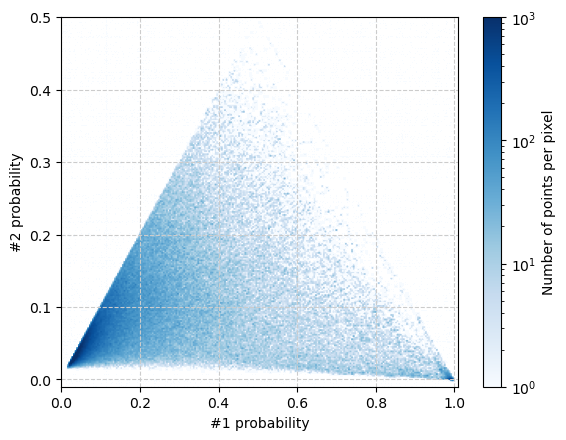

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['1'], top_values_0['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/tops_q_perfect_yeskicks.png', bbox_inches='tight')
plt.show()

### Check for the Mass dependency

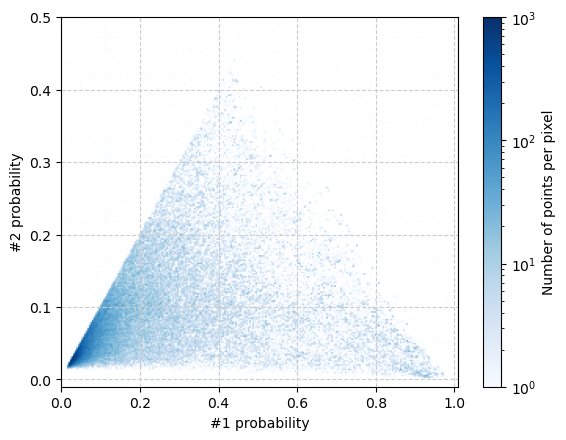

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0[top_values_0['Mass_0']<40]['1'], top_values_0[top_values_0['Mass_0']<40]['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/tops_q_perfect_mass_less_40_yeskicks.png', bbox_inches='tight')
plt.show()

### Record with wrong prediction

In [41]:
top_values_15 = top_values[top_values['Delta_Y']>=25]

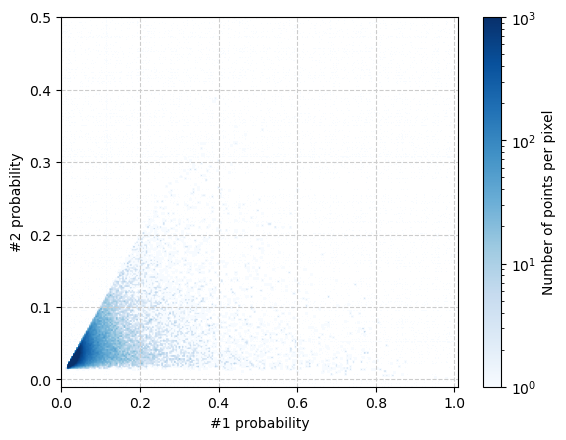

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['1'], top_values_15['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/tops_q_error_more_25_yeskicks.png', bbox_inches='tight')
plt.show()

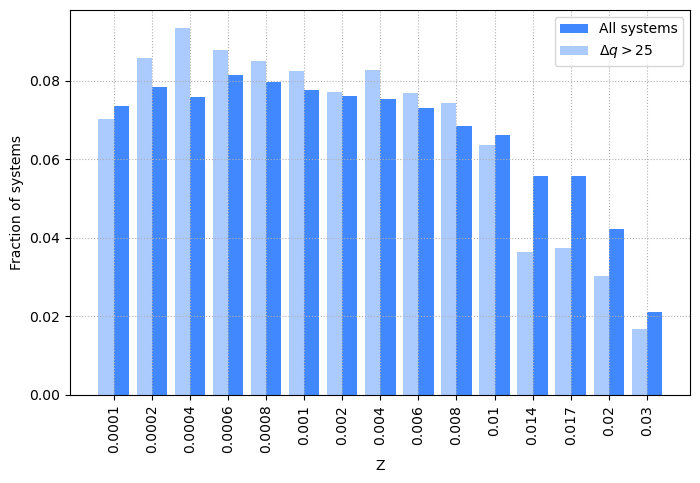

In [43]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta q>25$')
plt.xticks(rotation=90);
# plt.title('Metalliomparison');
plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.savefig('Figures/lcp/z_comparison_q_yeskicks.png', bbox_inches='tight')
plt.show()

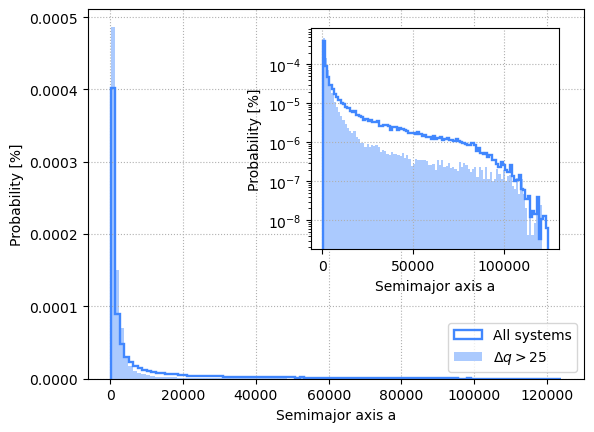

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['a'], bins=n_bins, label=r'$\Delta q>25$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('Figures/lcp/a_comparison_q_yeskicks.png', bbox_inches='tight')
plt.show()


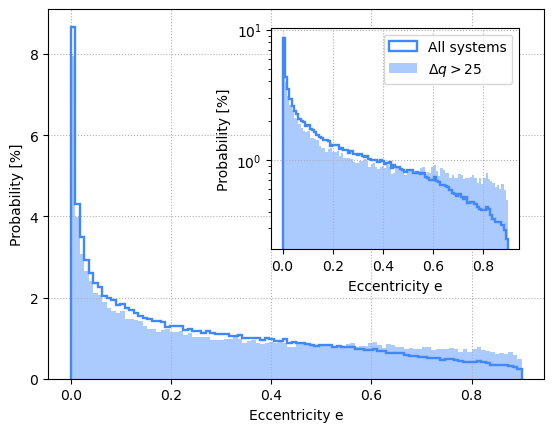

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['e'], bins=n_bins, label=r'$\Delta q>25$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['e'], bins=n_bins, log=True, density=True,label=r'$\Delta q>25$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()

plt.savefig('Figures/lcp/e_comparison_q_yeskicks.png', bbox_inches='tight')
plt.show()

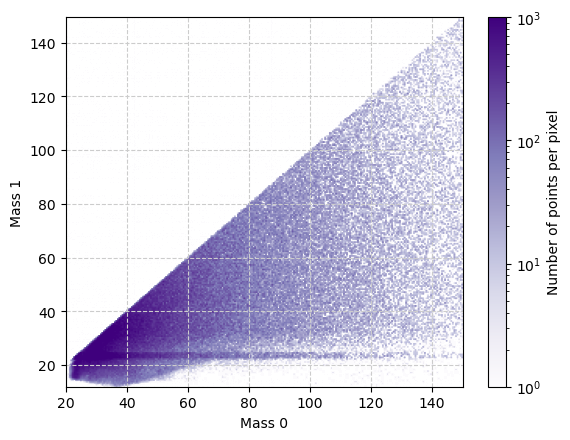

In [48]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values['Mass_0'], top_values['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/mass_0_mass_1.png', bbox_inches='tight')
plt.show()

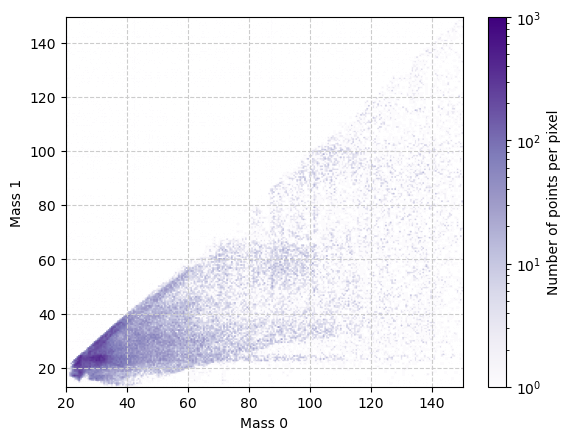

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['Mass_0'], top_values_15['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/mass_0_mass_1_error_25_q_yeskicks.png', bbox_inches='tight')
plt.show()

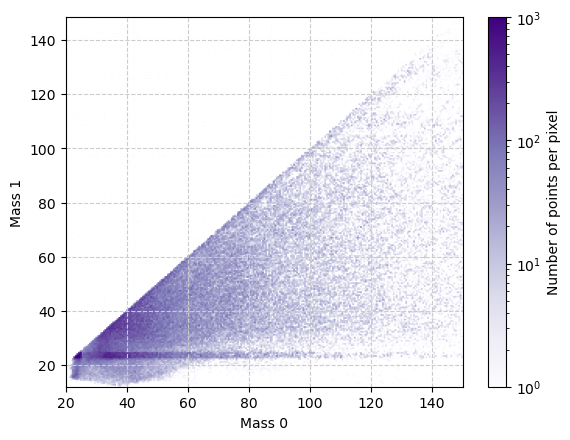

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['Mass_0'], top_values_0['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)

plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('Figures/lcp/mass_0_mass_1_all_right_yeskicks.png', bbox_inches='tight')
plt.show()

## Some simple statistics

In [52]:
print(f'Fraction of data in the flat region: {len(top_values[top_values["1"]<0.2])/len(top_values):.2f}')

print(f'Fraction of exactly guessed labels: {len(top_values_0)/len(top_values):.2f}')

print( f"Exactly guessed label in flat region / total points in flat region:{  len(top_values_0[top_values_0['1']<0.2])/len(top_values[top_values['1']<0.2])  :.2f}"   )

print( f"Exactly guessed label in flat region / total exactly flat labels:{  len(  top_values_0[ top_values_0[ '1' ]<0.2 ] )/len(top_values_0)  :.2f}"   )


Fraction of data in the flat region: 0.82
Fraction of exactly guessed labels: 0.23
Exactly guessed label in flat region / total points in flat region:0.16
Exactly guessed label in flat region / total exactly flat labels:0.58


# Focus on correctly classified systems

## Metallicity

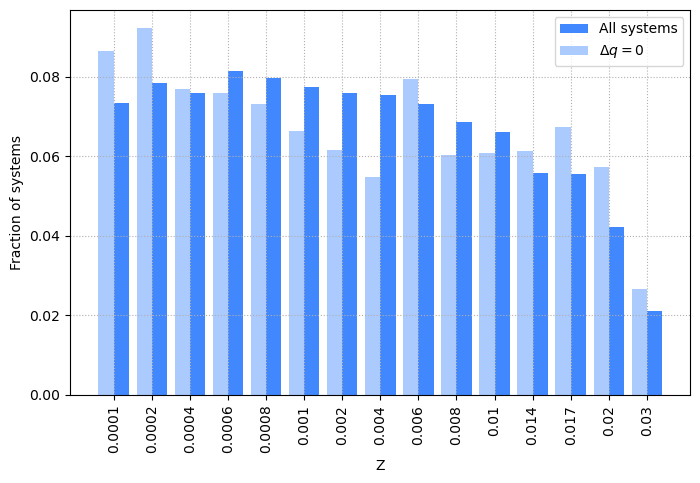

In [53]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_0['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta q = 0$')
plt.xticks(rotation=90);

plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.savefig('Figures/lcp/z_comparison_q_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()


## Semimajor axis

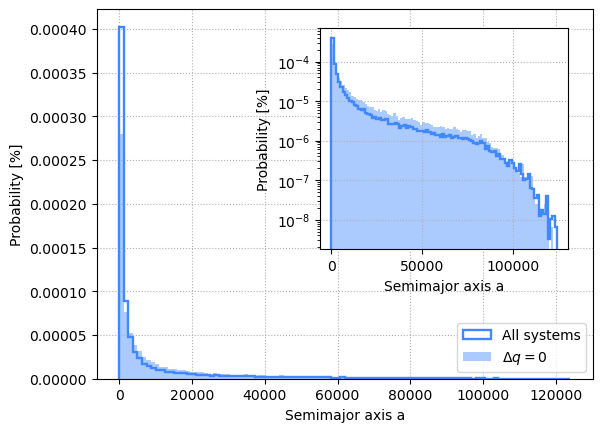

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['a'], bins=n_bins, label=r'$\Delta q = 0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('Figures/lcp/a_comparison_q_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()


## Eccentricity

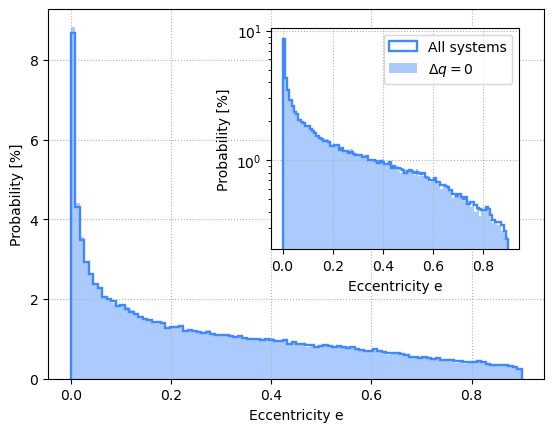

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['e'], bins=n_bins, label=r'$\Delta q = 0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['e'], bins=n_bins, log=True, density=True,label=r'$\Delta q = 0$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()


plt.savefig('Figures/lcp/e_comparison_q_one_peak_yeskicks.png', bbox_inches='tight')
plt.show()